# Import Libraries


In [1]:
import pandas as pd
import numpy as np
import nltk
import tensorflow as tf
from keras.layers import *
from tensorflow import *
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import *
import arabicstopwords.arabicstopwords as stp
from keras.preprocessing.sequence import pad_sequences
from nltk.stem import SnowballStemmer
import re
import os
from camel_tools.tokenizers.word import simple_word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import  TfidfVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from tashaphyne.stemming import ArabicLightStemmer
from sklearn.preprocessing import LabelEncoder
import warnings
from camel_tools.utils.dediac import dediac_ar
from camel_tools.utils.normalize import normalize_unicode
from camel_tools.utils.normalize import normalize_alef_maksura_ar
from camel_tools.utils.normalize import normalize_alef_ar
from camel_tools.utils.normalize import normalize_teh_marbuta_ar
import random
import emoji
from wordcloud import WordCloud
import plotly.express as px
import arabic_reshaper
from bidi.algorithm import get_display
from nltk import pos_tag
from plotly import graph_objects as go
from collections import Counter
import string
pd.options.display.max_rows = 100
pd.options.display.max_columns =None 
random.seed(10)

In [2]:
colors1 = ['#c0d0a2','#a7bd7c']
colors2 = ['#bdd390', '#e9f0da']
color3 = ['Salmon', 'FireBrick', 'MediumVioletRed', 'Tomato', 'Orange', 'Gold', 'DarkKhaki', 'Lavender', 'Plum', 'LimeGreen', 'MediumSpringGreen', 'Green', 'DeepSkyBlue', 'Aquamarine', 'MediumSlateBlue']

# Download Some Packages

In [3]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/osamaanmar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/osamaanmar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/osamaanmar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/osamaanmar/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# Ignore Warnings

In [4]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings(action='ignore')

# Read Data

In [5]:
df1 = pd.read_csv('train.csv')
df2 = pd.read_csv('dev.csv')
df3 = pd.read_csv('test.csv')
Corpus = pd.concat([df1, df2, df3], ignore_index=True)
Corpus.rename(columns={'txt': 'Text', 'sentiment': 'Sentiment'}, inplace=True)
Corpus.drop('clean_txt', axis=1, inplace=True)
Corpus

,Sentiment,Text
0,Negative,مقتطفات من كتاب سأخون وطني للكاتب محمد الماغو...
1,Positive,كتاب جدا ً رائع يتكلم عن التعامل مع الاخرين ب...
2,Positive,"كتاب واقعي جدا,كُتب باسلوب مُعاصر وحديث.استمت..."
3,Positive,وبما انى من المولعين ب د.مصطفى محمود ومن أوائ...
4,Positive,اول حاجة طبعا في تعليقي لازم يكون عن الاسلوب ...
...,...,...
16434,Negative,بين الشفقة و العطف أقيم هذه الرواية يؤسفني جد...
16435,Negative,"أوصيك بالدقة . لا بالوضوح . "" فاليري"" تقريباً..."
16436,Negative,للاسف الشديد لم يعجبني الكتاب ، شعرت بالملل م...
16437,Positive,من بداية الرواية وانا احاول تمالك نفسي ولكن ت...


# Percantage Of Each Sentiment

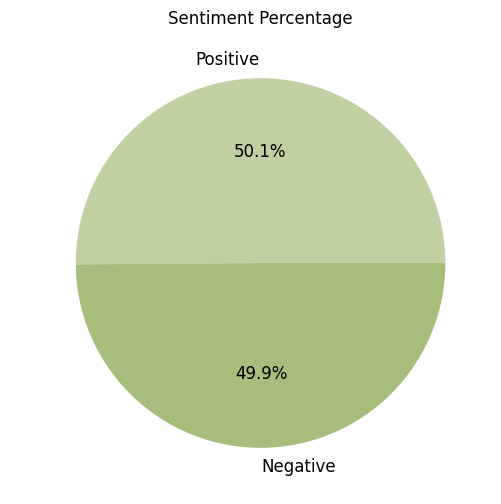

In [6]:
Corpus['Sentiment'].value_counts().plot.pie(autopct = '%0.1f%%',
                                                    textprops = {'size': 'large'},
                                                    title = 'Sentiment Percentage',
                                                    figsize = (6,6),
                                                    colors = colors1,
                                                    ylabel = ' ');

# Count Of Each Sentiment

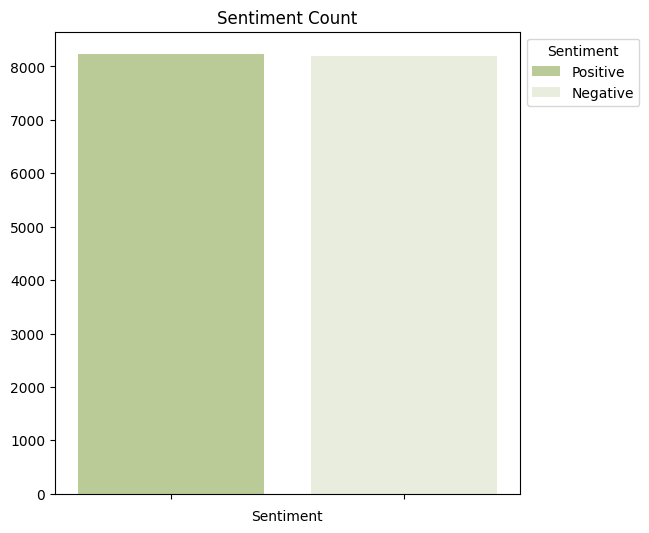

In [7]:
ax, fig = plt.subplots(figsize = (6,6))
ax =sns.countplot(x='Sentiment', data=Corpus, dodge=False, hue='Sentiment',  order= Corpus['Sentiment'].value_counts().index, hue_order =Corpus['Sentiment'].value_counts().index,  palette=colors2);
ax.set(xticklabels=[]) 
ax.set(ylabel=None) 
plt.title('Sentiment Count')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

# Number Of Sentences

In [8]:
Corpus['NumberOfSentences'] = Corpus['Text'].apply(lambda n:len(nltk.tokenize.sent_tokenize(n)))
Corpus.drop(Corpus[ Corpus["NumberOfSentences"] == 0].index, inplace = True)
Corpus['NumberOfSentences'].sum()

48524

# Average Number Of Sentences

In [9]:
AverageNumberOfSentence = int(np.round(Corpus["NumberOfSentences"].mean()))
AverageNumberOfSentence

3

# Maximum Number Of Sentences

In [10]:
MaximumNumberOfSentence = Corpus["NumberOfSentences"].max()
MaximumNumberOfSentence

326

# Minimum Number Of Sentences

In [11]:
MinimumNumberOfSentence = Corpus["NumberOfSentences"].min()
MinimumNumberOfSentence

1

# POS Tagging (Parts of Speech Tagging)

In [12]:
Corpus['Tagged'] = Corpus['Text'].str.split().apply(pos_tag)
Corpus.reset_index(inplace=True, drop=True)
Corpus

,Sentiment,Text,NumberOfSentences,Tagged
0,Negative,مقتطفات من كتاب سأخون وطني للكاتب محمد الماغو...,31,"[(مقتطفات, JJ), (من, NNP), (كتاب, NNP), (سأخون..."
1,Positive,كتاب جدا ً رائع يتكلم عن التعامل مع الاخرين ب...,2,"[(كتاب, JJ), (جدا, NNP), (ً, NNP), (رائع, NNP)..."
2,Positive,"كتاب واقعي جدا,كُتب باسلوب مُعاصر وحديث.استمت...",1,"[(كتاب, JJ), (واقعي, NNP), (جدا,كُتب, NNP), (ب..."
3,Positive,وبما انى من المولعين ب د.مصطفى محمود ومن أوائ...,3,"[(وبما, JJ), (انى, NNP), (من, NNP), (المولعين,..."
4,Positive,اول حاجة طبعا في تعليقي لازم يكون عن الاسلوب ...,4,"[(اول, JJ), (حاجة, NNP), (طبعا, NNP), (في, NNP..."
...,...,...,...,...
16434,Negative,بين الشفقة و العطف أقيم هذه الرواية يؤسفني جد...,1,"[(بين, JJ), (الشفقة, NNP), (و, NNP), (العطف, N..."
16435,Negative,"أوصيك بالدقة . لا بالوضوح . "" فاليري"" تقريباً...",3,"[(أوصيك, JJ), (بالدقة, NNP), (., .), (لا, NN),..."
16436,Negative,للاسف الشديد لم يعجبني الكتاب ، شعرت بالملل م...,2,"[(للاسف, JJ), (الشديد, NNP), (لم, NNP), (يعجبن..."
16437,Positive,من بداية الرواية وانا احاول تمالك نفسي ولكن ت...,14,"[(من, JJ), (بداية, NNP), (الرواية, NNP), (وانا..."


# WordCloud

In [13]:
def word_cloud_(Sentiment):
    text = str(Corpus[Corpus['Sentiment'] == Sentiment])
    text = arabic_reshaper.reshape(text)
    text = get_display(text)
    wordcloud = WordCloud(font_path='arial.ttf',background_color='white', mode='RGB',width=1200,height=600).generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation='catrom')
    plt.axis("off")
    plt.title('Word Cloud For {} Sentiment'.format(Sentiment))
    plt.show()

**1-Positive**

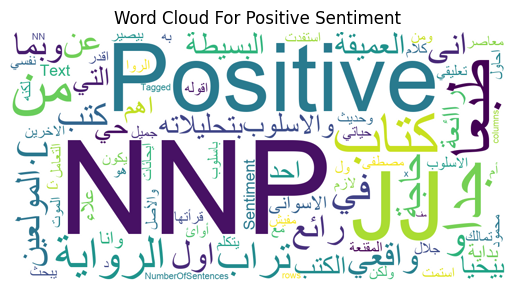

In [14]:
word_cloud_('Positive')

**2-Negative**

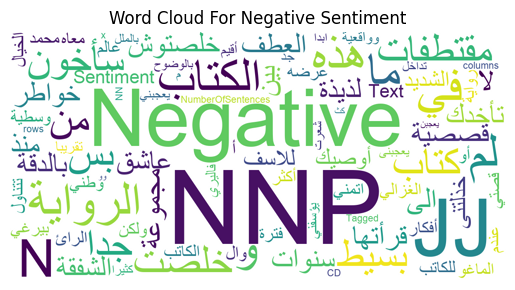

In [15]:
word_cloud_('Negative')

# Text Normalization

In [16]:
def remove_emojis(text):
     text = emoji.replace_emoji(text, replace="")
     return text

def remove_hashtags(text):
     text =  re.sub("#[ا-ي٠-٩a-zA-Z0-9]+","", text)
     return text   

def remove_emails(text):
     text = re.sub("[a-zA-Z0-9-_.]+@[a-zA-Z]+.[a-zA-Z]+","", text)  
     return text    

def remove_url(text):
     text = re.sub(r'http\S+', '', text, flags=re.MULTILINE)
     return text

def remove_mention(text):
     text = re.sub("@[ا-ي٠-٩a-zA-Z0-9]+","", text)
     return text

def remove_duplicate_char(text):
     text = re.sub(r'(.)\1+', r'\1\1', text)
     return text

def remove_single_char(text):
     text = ' '.join( [w for w in text.split() if len(w)>1] )
     return text

def remove_special_charachter_(text):
     Punctuations = '`؛،؟.,«»÷-' + string.punctuation
     for punctuation in Punctuations:
        text = text.replace(punctuation, ' ')
     return text   

def remove_new_line_char(text):
     text = text.replace('\n', ' ')
     return text  
 
def remove_number(text):
     text = re.sub(r'\d+', '', text)
     return text

def remove_html_tags(text):
    text = re.sub("<.*?>", ' ', text)
    return text

def remove_arabic_diacritics_(text):
     text = dediac_ar(text)
     return text

def normalize_arabic_unicode_(text):
     text = normalize_unicode(text)
     return text

def normalize_alef_maksura_ar_(text):
     text = normalize_alef_maksura_ar(text)
     return text

def normalize_alef_ar_(text):
     text = normalize_alef_ar(text)
     return text

def normalize_teh_marbuta_ar_(text):
     text = normalize_teh_marbuta_ar(text)
     return text

def remove_non_arabic(text):
    text = re.sub('[a-zA-Z]', '', text)
    return text

def remove_whitespace(text):
     text = text.strip()
     return text 

def remove_unicode_characters_(text):
     for character in text:
        if (ord(character) < 47) or ((ord(character) > 123 and ord(character) < 1568)) or ((ord(character) > 1641 and ord(character) < 8239)) :
         text = text.replace(character, ' ')
     return text

def stemmer_(text):
     stemmer = SnowballStemmer('arabic')
     text = [stemmer.stem(word) for word in text]
     return text


def remove_longest_than_(text):
     "Remove All Words That Longest Than The Longest Word In Arabic"
     for word in text.split():
          if len(word) >=16:
               text = text.replace(word, '')
     return text

def remove_stop_words(text):
     StopWords1 = set(stp.stopwords_list())
     StopWords2 = set(open('ArabicStopWord.txt','r', encoding='Utf-8').read().split('\n'))
     StopWords = StopWords1.union(StopWords2)
     text = simple_word_tokenize(text)
     text = [word for word in text if word not in StopWords]
     return ' '.join(text)

In [17]:
def text_normalization(text):
    text = remove_non_arabic(text)
    text = remove_emojis(text)
    text = remove_hashtags(text)
    text = remove_emails(text)
    text = remove_url(text)
    text = remove_mention(text)
    text = remove_html_tags(text)
    text = remove_duplicate_char(text)
    text = remove_number(text)
    text = normalize_arabic_unicode_(text)
    text = remove_single_char(text)
    text = remove_special_charachter_(text)
    text = remove_stop_words(text)
    text = normalize_alef_ar(text)
    text = normalize_alef_maksura_ar(text)
    text = normalize_teh_marbuta_ar(text)
    text = remove_arabic_diacritics_(text)
    text = remove_longest_than_(text)
    text = remove_new_line_char(text)
    text = remove_unicode_characters_(text)
    text = remove_whitespace(text)
    text = stemmer_(text)
    return ''.join(text)

In [18]:
Corpus['Normalized_Text'] = Corpus['Text'].apply(text_normalization)

# Bigrams

In [19]:
Corpus['Bigrams'] = Corpus['Normalized_Text'].apply(lambda x: list(nltk.bigrams(x.split( ))))
Corpus['Bigrams'][100]

[('روايه', 'ممتعه'),
 ('ممتعه', 'وربط'),
 ('وربط', 'متميز'),
 ('متميز', 'الشخصيات'),
 ('الشخصيات', 'يعيبها'),
 ('يعيبها', 'كثره'),
 ('كثره', 'المشاهد'),
 ('المشاهد', 'الجنسيه'),
 ('الجنسيه', 'تخدم'),
 ('تخدم', 'الروايه'),
 ('الروايه', 'وجهه'),
 ('وجهه', 'نظري'),
 ('نظري', 'المتواضعه'),
 ('المتواضعه', 'طبعا')]

# Trigrams

In [20]:
Corpus['Trigrams'] = Corpus['Normalized_Text'].apply(lambda x: list(nltk.trigrams(x.split( ))))
Corpus['Trigrams'][100]

[('روايه', 'ممتعه', 'وربط'),
 ('ممتعه', 'وربط', 'متميز'),
 ('وربط', 'متميز', 'الشخصيات'),
 ('متميز', 'الشخصيات', 'يعيبها'),
 ('الشخصيات', 'يعيبها', 'كثره'),
 ('يعيبها', 'كثره', 'المشاهد'),
 ('كثره', 'المشاهد', 'الجنسيه'),
 ('المشاهد', 'الجنسيه', 'تخدم'),
 ('الجنسيه', 'تخدم', 'الروايه'),
 ('تخدم', 'الروايه', 'وجهه'),
 ('الروايه', 'وجهه', 'نظري'),
 ('وجهه', 'نظري', 'المتواضعه'),
 ('نظري', 'المتواضعه', 'طبعا')]

# Ngrams

In [21]:
Corpus['Ngrams'] = Corpus['Normalized_Text'].apply(lambda x: list(nltk.ngrams(x.split( ), 4)))
Corpus['Ngrams'][100]

[('روايه', 'ممتعه', 'وربط', 'متميز'),
 ('ممتعه', 'وربط', 'متميز', 'الشخصيات'),
 ('وربط', 'متميز', 'الشخصيات', 'يعيبها'),
 ('متميز', 'الشخصيات', 'يعيبها', 'كثره'),
 ('الشخصيات', 'يعيبها', 'كثره', 'المشاهد'),
 ('يعيبها', 'كثره', 'المشاهد', 'الجنسيه'),
 ('كثره', 'المشاهد', 'الجنسيه', 'تخدم'),
 ('المشاهد', 'الجنسيه', 'تخدم', 'الروايه'),
 ('الجنسيه', 'تخدم', 'الروايه', 'وجهه'),
 ('تخدم', 'الروايه', 'وجهه', 'نظري'),
 ('الروايه', 'وجهه', 'نظري', 'المتواضعه'),
 ('وجهه', 'نظري', 'المتواضعه', 'طبعا')]

# Most Frequent Words 

In [22]:
MostFrequentWord = Counter((Corpus['Normalized_Text']).str.split().explode()).most_common(15)
MostFrequentWordDF = pd.DataFrame(MostFrequentWord, columns=('Word', 'Count'))
MostFrequentWordDF

,Word,Count
0,الروايه,7347
1,الكتاب,6617
2,كتاب,3828
3,روايه,3154
4,الكاتب,2793
5,الله,2312
6,اللي,1878
7,مش,1444
8,رائع,1431
9,الاحداث,1247


In [23]:
fig = go.Figure(go.Funnel(
    y = MostFrequentWordDF['Word'].tolist(),
    x = MostFrequentWordDF['Count'].tolist(),
    marker = {"color": color3}))
fig.show()

In [24]:
fig = px.bar(MostFrequentWordDF, y='Word', x='Count',  orientation='h')
fig.show()

# Number Of Words 

In [25]:
Corpus["Number of Words"] = Corpus["Normalized_Text"].apply(lambda n:len(simple_word_tokenize(n)))
Corpus.drop(Corpus[ Corpus["Number of Words"] == 0].index, inplace = True)
Corpus["Number of Words"].sum()

569175

# Number Of Charachters 

In [26]:
Corpus["Number of Charachters"] = Corpus["Normalized_Text"].str.len()
Corpus["Number of Charachters"].sum()

3543392

# Average Number Of Words 

In [27]:
AverageNaumberOfWords = np.round((Corpus["Number of Words"].mean()))
AverageNaumberOfWords

35.0

# Average Number Of Charachters 

In [28]:
AverageNumberOfCharachters = np.round(Corpus["Number of Charachters"].mean())
AverageNumberOfCharachters

216.0

# Maximum Number Of Word

In [29]:
MaximumNaumberOfWords = Corpus["Number of Words"].max()
MaximumNaumberOfWords

1853

# Maximum Number Of Charachters 

In [30]:
MaximumNumberOfCharachters = Corpus['Number of Charachters'].max() 
MaximumNumberOfCharachters

11593

# Minimum Number Of Words

In [31]:
MimimumNaumberOfWords = Corpus["Number of Words"].min()
MimimumNaumberOfWords

1

# Minimum Number Of Charachters 

In [32]:
MinimumNumberOfCharachters = int(Corpus['Number of Charachters'].mean() )
MinimumNumberOfCharachters

215

# Split The DataSet Into Independent Variables , And Dependent Variable (Y)

In [33]:
Corpus = Corpus[['Normalized_Text', 'Sentiment']]

In [34]:
X= Corpus['Normalized_Text']
y = Corpus['Sentiment']

# Label Encoder

In [35]:
y = LabelEncoder().fit_transform(y)

# Split The Dataset Into Training And Testing

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

# TfidfVectorizer

In [37]:
Tfidf = TfidfVectorizer()
X_train_Tfidf = Tfidf.fit_transform(X_train)
X_test_Tfidf = Tfidf.transform(X_test)

In [38]:
vocab = Tfidf.vocabulary_
vocab

{'كتاب': 38992,
 'رائع': 29888,
 'ايقظ': 16208,
 'بداخلي': 19352,
 'مشاعر': 47959,
 'الحمي': 7788,
 'ممتلاكات': 49375,
 'المسلمين': 12948,
 'الكتاب': 11392,
 'يصبح': 65883,
 'النثر': 14172,
 'شعرا': 32673,
 'يقف': 66703,
 'المسافه': 12808,
 'الاساليب': 5003,
 'الادبيه': 4867,
 'روايه': 30530,
 'ديوان': 29675,
 'وكفي': 60981,
 'اعتقد': 3582,
 'الضجه': 9756,
 'اللي': 11752,
 'اثارتها': 724,
 'الروايه': 8652,
 'اكبر': 4436,
 'حجم': 27732,
 'استمتع': 2630,
 'اطلاقا': 3397,
 'بالثلاث': 17163,
 'ارباع': 1924,
 'اسلوبه': 2845,
 'طفولي': 33875,
 'السرد': 8966,
 'الشخصيات': 9322,
 'باهته': 18304,
 'عميقه': 35099,
 'بالمره': 17961,
 'اني': 15759,
 'يومين': 67562,
 'قراءه': 38075,
 'اتذكر': 421,
 'اسماء': 2856,
 'القليله': 11251,
 'الاحداث': 4778,
 'والاسلوب': 53824,
 'يتكرران': 64389,
 'البدايه': 6035,
 'ممل': 49417,
 'يستخدم': 65504,
 'الجمل': 7404,
 'التعبيريه': 6721,
 'مرارا': 47365,
 'وتكرارا': 57891,
 'حد': 27740,
 'يدفعك': 65126,
 'الجنون': 7433,
 'وفكرت': 60590,
 'التوقف': 7093,
 'القراءه

# Models

In [39]:
def models_(model_name):
    model = model_name
    model.fit(X_train_Tfidf, y_train)
    y_pred = model.predict(X_test_Tfidf)
    return y_pred

# Confusion Matrix

In [40]:
def confusion_matrix_(Real, Prediction):
        ConfusionMatrix = confusion_matrix(Real, Prediction)
        return ConfusionMatrix

# Generate True Positive, False Positive, True Negative, False Negative

In [41]:
def positive_negative(Confusin_Matrix):
    False_Postive = Confusin_Matrix[0, 1]

    True_Positive = Confusin_Matrix[0, 0]

    False_Negative = Confusin_Matrix[1, 0]
    
    True_Negative = Confusin_Matrix[1, 1]

    return False_Postive, True_Positive, False_Negative, True_Negative

# Performance Merics

In [42]:
def performance_metrics(False_Postive, True_Positive, False_Negative, True_Negative):
     Accuracy = (True_Positive + True_Negative) / (True_Positive + True_Negative + False_Postive + False_Negative)
     Precision = True_Positive / (True_Positive+ False_Postive)
     Sensitivity = True_Positive / (True_Positive  + False_Negative)
     Specificity = True_Negative / (True_Negative + False_Negative)
     F1Score = (True_Positive) / ((True_Positive) + (0.5 *(False_Postive + False_Negative)))
     Error = 1 - Accuracy
     MetricsValues = pd.DataFrame(index=['Accuracy', 'Precision', 'Sensitivity', 'Specificity', 'F1Score', 'Error'], columns=['Values'], data=[Accuracy, Precision, Sensitivity, Specificity, F1Score, Error])
     return MetricsValues


# Machine Learning

**1. Naive Bayes**

In [43]:
model_name1 = MultinomialNB()
y_pred1 = models_(model_name1)

In [44]:
cm1 = confusion_matrix_(y_test, y_pred1)

In [45]:
False_Postive, True_Positive, False_Negative, True_Negative = positive_negative(cm1)

In [46]:
MetricsValues1 = performance_metrics(False_Postive, True_Positive, False_Negative, True_Negative)

In [47]:
MetricsValues1

,Values
Accuracy,0.898692
Precision,0.889773
Sensitivity,0.904732
Specificity,0.907497
F1Score,0.897190
Error,0.101308


**2. Logistic Regression**

In [48]:
model_name2 = LogisticRegression()
y_pred2 = models_(model_name2)

In [49]:
cm2 = confusion_matrix_(y_test, y_pred2)

In [50]:
False_Postive2, True_Positive2, False_Negative2, True_Negative2 = positive_negative(cm2)
MetricsValues2 = performance_metrics(False_Postive2, True_Positive2, False_Negative2, True_Negative2)
MetricsValues2

,Values
Accuracy,0.895345
Precision,0.898959
Sensitivity,0.891318
Specificity,0.891778
F1Score,0.895122
Error,0.104655


**3. Decision Tree**

In [51]:
model_name3 = DecisionTreeClassifier(criterion = 'entropy')
y_pred3 = models_(model_name3)

In [52]:
cm3 = confusion_matrix_(y_test, y_pred3)

In [53]:
False_Postive3, True_Positive3, False_Negative3, True_Negative3 = positive_negative(cm3)
MetricsValues3 = performance_metrics(False_Postive3, True_Positive3, False_Negative3, True_Negative3)
MetricsValues3

,Values
Accuracy,0.860055
Precision,0.848132
Sensitivity,0.867251
Specificity,0.871826
F1Score,0.857585
Error,0.139945


**4. K Nearest Neighbor**

In [54]:
model_name4 = KNeighborsClassifier(metric='cosine', n_neighbors=5)
y_pred4 = models_(model_name4)

In [55]:
cm4 = confusion_matrix_(y_test, y_pred4)

In [56]:
False_Postive4, True_Positive4, False_Negative4, True_Negative4 = positive_negative(cm4)
MetricsValues4 = performance_metrics(False_Postive4, True_Positive4, False_Negative4, True_Negative4)
MetricsValues4

,Values
Accuracy,0.815029
Precision,0.752603
Sensitivity,0.857641
Specificity,0.876663
F1Score,0.801696
Error,0.184971


**5. Random Forest**

In [57]:
model_name5 = RandomForestClassifier(criterion = 'entropy', n_estimators=100)
y_pred5 = models_(model_name5)

In [58]:
cm5 = confusion_matrix_(y_test, y_pred5)

In [59]:
False_Postive5, True_Positive5, False_Negative5, True_Negative5 = positive_negative(cm5)
MetricsValues5 = performance_metrics(False_Postive5, True_Positive5, False_Negative5, True_Negative5)
MetricsValues5

,Values
Accuracy,0.902038
Precision,0.916718
Sensitivity,0.889483
Specificity,0.887545
F1Score,0.902895
Error,0.097962


**6.SGD Classifier**

In [60]:
model_name6 = SGDClassifier(loss='hinge')
y_pred6 = models_(model_name6)

In [61]:
cm6 = confusion_matrix_(y_test, y_pred6)

In [62]:
False_Postive6, True_Positive6, False_Negative6, True_Negative6 = positive_negative(cm6)
MetricsValues6 = performance_metrics(False_Postive6, True_Positive6, False_Negative6, True_Negative6)
MetricsValues6

,Values
Accuracy,0.905081
Precision,0.902021
Sensitivity,0.906462
Specificity,0.908102
F1Score,0.904236
Error,0.094919


**7.Support  Vector Machine**

In [63]:
model_name7 = SVC(kernel='rbf')
y_pred7 = models_(model_name7)

In [64]:
cm7 = confusion_matrix_(y_test, y_pred7)

In [65]:
False_Postive7, True_Positive7, False_Negative7, True_Negative7 = positive_negative(cm7)
MetricsValues7 = performance_metrics(False_Postive7, True_Positive7, False_Negative7, True_Negative7)
MetricsValues7

,Values
Accuracy,0.913903
Precision,0.912431
Sensitivity,0.914110
Specificity,0.915357
F1Score,0.913270
Error,0.086097


**8- Multilayer Perceptron (MLP) Classifier**

In [66]:
model_name8 = MLPClassifier(hidden_layer_sizes = 16, activation='tanh')
y_pred8 = models_(model_name8)

In [67]:
cm8 = confusion_matrix_(y_test, y_pred8)

In [68]:
False_Postive8, True_Positive8, False_Negative8, True_Negative8 = positive_negative(cm8)
MetricsValues8 = performance_metrics(False_Postive8, True_Positive8, False_Negative8, True_Negative8)
MetricsValues8

,Values
Accuracy,0.912078
Precision,0.902633
Sensitivity,0.918953
Specificity,0.921403
F1Score,0.910720
Error,0.087922


# Deep Learning

In [69]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index)+1
embedding_dim = 16


In [70]:
X_train_seqs = tokenizer.texts_to_sequences(X_train)
X_test_seqs = tokenizer.texts_to_sequences(X_test)
max_length = len(max(X_train_seqs, key=len))

In [71]:
encoded_X_train = sequence.pad_sequences(X_train_seqs, maxlen=max_length)
encoded_X_test = sequence.pad_sequences(X_test_seqs, maxlen=max_length)


In [72]:
y_train_enc = keras.utils.to_categorical(y_train)
y_test_enc = keras.utils.to_categorical(y_test)

In [73]:
Callback = tf.keras.callbacks.EarlyStopping(
                    monitor="accuracy",
                    mode="max",
                )

**9-Convolutional Neural Network**

In [74]:
model = tf.keras.Sequential([
                Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
                Conv1D(filters=32, kernel_size = 2, activation='relu'),
                GlobalAveragePooling1D(),
                Dropout(0.8),
                Dense(1, activation= 'sigmoid')
                ])

In [75]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [76]:
history = model.fit(encoded_X_train, y_train,
                    epochs=50,
                    validation_data=(encoded_X_test, y_test),
                    batch_size=16,
                    callbacks=[Callback])

Epoch 1/50
822/822 [==============================] - 57s 69ms/step - loss: 0.6918 - accuracy: 0.5329 - val_loss: 0.6870 - val_accuracy: 0.6507
Epoch 2/50
822/822 [==============================] - 59s 72ms/step - loss: 0.6479 - accuracy: 0.6879 - val_loss: 0.5978 - val_accuracy: 0.8357
Epoch 3/50
822/822 [==============================] - 41s 50ms/step - loss: 0.4971 - accuracy: 0.8389 - val_loss: 0.4542 - val_accuracy: 0.8710
Epoch 4/50
822/822 [==============================] - 33s 40ms/step - loss: 0.3698 - accuracy: 0.8889 - val_loss: 0.3674 - val_accuracy: 0.8902
Epoch 5/50
822/822 [==============================] - 33s 40ms/step - loss: 0.2830 - accuracy: 0.9140 - val_loss: 0.3158 - val_accuracy: 0.8981
Epoch 6/50
822/822 [==============================] - 32s 39ms/step - loss: 0.2303 - accuracy: 0.9312 - val_loss: 0.2839 - val_accuracy: 0.9026
Epoch 7/50
822/822 [==============================] - 31s 38ms/step - loss: 0.1951 - accuracy: 0.9399 - val_loss: 0.2616 - val_accuracy:

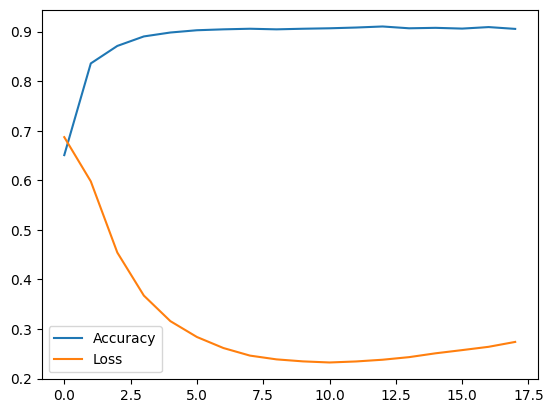

In [77]:
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

plt.plot(val_acc, label='Accuracy')
plt.plot(val_loss, label='Loss')
plt.legend()
plt.show()

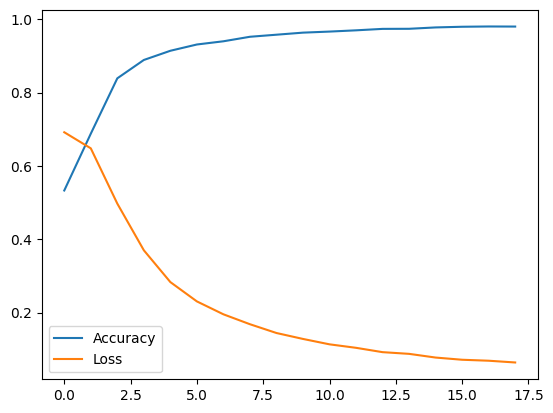

In [78]:
acc = history.history['accuracy']
loss = history.history['loss']

plt.plot(acc, label='Accuracy')
plt.plot(loss, label='Loss')
plt.legend()
plt.show()

In [79]:
loss, accuracy = model.evaluate(encoded_X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(encoded_X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9908
Testing Accuracy:  0.9054


**10-Deep Neural Network**

In [80]:
model = tf.keras.Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
        Dropout(0.2),
        GlobalAveragePooling1D(),
        Dropout(0.3),
        Dense(8, activation="relu"),
        Dense(1, activation='sigmoid')])

In [81]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [82]:
history = model.fit(encoded_X_train, y_train,
                    epochs=50,
                    validation_data=(encoded_X_test, y_test),
                    batch_size=16,
                    callbacks=[Callback])

Epoch 1/50
822/822 [==============================] - 65s 78ms/step - loss: 0.6929 - accuracy: 0.5074 - val_loss: 0.6919 - val_accuracy: 0.5041
Epoch 2/50
822/822 [==============================] - 57s 70ms/step - loss: 0.6881 - accuracy: 0.5561 - val_loss: 0.6814 - val_accuracy: 0.5902
Epoch 3/50
822/822 [==============================] - 58s 70ms/step - loss: 0.6514 - accuracy: 0.6706 - val_loss: 0.6168 - val_accuracy: 0.8077
Epoch 4/50
822/822 [==============================] - 55s 67ms/step - loss: 0.5384 - accuracy: 0.7941 - val_loss: 0.4977 - val_accuracy: 0.8470
Epoch 5/50
822/822 [==============================] - 56s 68ms/step - loss: 0.4132 - accuracy: 0.8531 - val_loss: 0.4068 - val_accuracy: 0.8616
Epoch 6/50
822/822 [==============================] - 55s 67ms/step - loss: 0.3293 - accuracy: 0.8839 - val_loss: 0.3518 - val_accuracy: 0.8704
Epoch 7/50
822/822 [==============================] - 55s 67ms/step - loss: 0.2730 - accuracy: 0.8975 - val_loss: 0.3238 - val_accuracy:

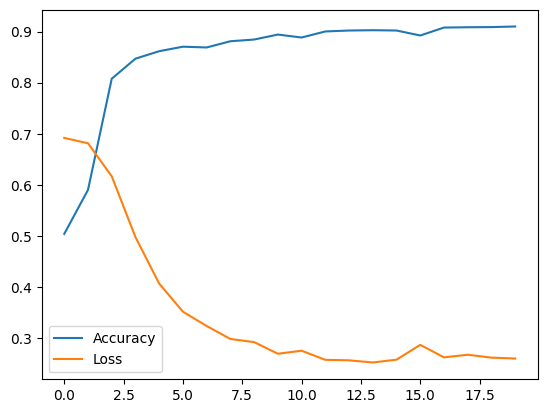

In [83]:
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

plt.plot(val_acc, label='Accuracy')
plt.plot(val_loss, label='Loss')
plt.legend()
plt.show()

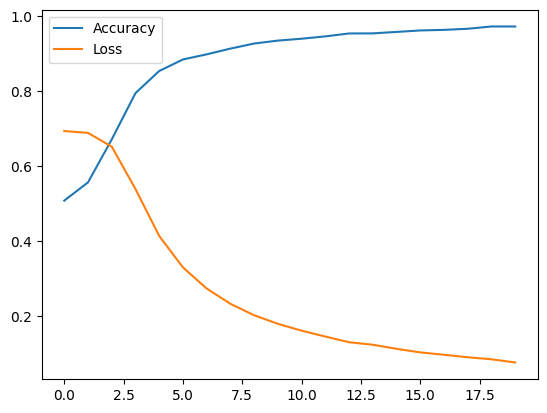

In [84]:
acc = history.history['accuracy']
loss = history.history['loss']

plt.plot(acc, label='Accuracy')
plt.plot(loss, label='Loss')
plt.legend()
plt.show()

In [85]:
loss, accuracy = model.evaluate(encoded_X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(encoded_X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9804
Testing Accuracy:  0.9099


**11-Recurrent Neural Networks**

In [86]:
model = tf.keras.Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
        LSTM(32, return_sequences=False),  
        Dropout(0.2),      
        Dense(1, activation='sigmoid')])

In [87]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [88]:
history = model.fit(encoded_X_train, y_train,
                    epochs=50,
                    validation_data=(encoded_X_test, y_test),
                    batch_size=16,
                    callbacks=[Callback])

Epoch 1/50
822/822 [==============================] - 108s 125ms/step - loss: 0.4478 - accuracy: 0.7881 - val_loss: 0.2675 - val_accuracy: 0.8935
Epoch 2/50
822/822 [==============================] - 101s 123ms/step - loss: 0.1275 - accuracy: 0.9538 - val_loss: 0.2457 - val_accuracy: 0.9112
Epoch 3/50
822/822 [==============================] - 96s 117ms/step - loss: 0.0415 - accuracy: 0.9871 - val_loss: 0.2835 - val_accuracy: 0.9115
Epoch 4/50
822/822 [==============================] - 99s 121ms/step - loss: 0.0187 - accuracy: 0.9944 - val_loss: 0.3441 - val_accuracy: 0.9133
Epoch 5/50
822/822 [==============================] - 91s 111ms/step - loss: 0.0121 - accuracy: 0.9956 - val_loss: 0.4070 - val_accuracy: 0.9084
Epoch 6/50
822/822 [==============================] - 102s 124ms/step - loss: 0.0082 - accuracy: 0.9972 - val_loss: 0.4206 - val_accuracy: 0.9081
Epoch 7/50
822/822 [==============================] - 104s 127ms/step - loss: 0.0071 - accuracy: 0.9976 - val_loss: 0.4624 - va

In [89]:
loss, accuracy = model.evaluate(encoded_X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(encoded_X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9987
Testing Accuracy:  0.9057
